<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/ARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 718 kB 5.1 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [13]:
import torch
from torch import nn

import pyro
from pyro.nn import PyroModule
from pyro.nn import PyroSample
from pyro.infer import MCMC, NUTS, HMC, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoContinuous
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

In [7]:
# Making training data
def make_training_data(num_samples, dims, sigma, mu=0):
  """
  Creates training data when half of the regressors are 0
  """
  x = np.random.randn(num_samples, dims).astype(np.float64)
  w = sigma * np.random.randn(1,dims).astype(np.float64)
  noise = np.random.randn(num_samples).astype(np.float64)
  noise = 0
  w[:,:int(dims/2)] = 0.
  y = np.matmul(x, w.T) + (noise/2) + mu

  y = torch.tensor(y, dtype = torch.float)
  x = torch.tensor(x, dtype = torch.float)
  return y, x, w


def sep_training_test(y,x,test):
  y_train = y[test:,:]
  x_train = x[test:,:]
  
  y_test = y[:test,:]
  x_test = x[:test,:]
  return y_train, y_test, x_train, x_test

num_features = 250

y, x, w = make_training_data(11000, num_features, 10, mu=0)
y_train, y_test, x_train, x_test = sep_training_test(y,x,1000)

In [8]:
# Define the bayesian model in pyro
def model(x, y=None):
      num_features = x.shape[1]

      alpha = pyro.sample('alpha', dist.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).expand([num_features]).to_event(1))
      one_over_sqrt_alpha = 1/torch.sqrt(alpha)

      sigma2 = pyro.sample('sigma2', dist.InverseGamma(torch.tensor([1.0]), torch.tensor([1.0])))
      sigma = torch.sqrt(sigma2)

      beta = pyro.sample('beta', dist.Normal(torch.tensor([0.0]), sigma*one_over_sqrt_alpha).expand([num_features]).to_event(1))

      mean = torch.matmul(x, beta)

      with pyro.plate("data", x.shape[0]):          
          outcome_dist = dist.Normal(mean, sigma)          
          observation = pyro.sample("obs", outcome_dist, obs=y)

In [19]:
# Define the ADVI components: Guide, Optimizer and SVI
guide = AutoDiagonalNormal(model)
adaprop = pyro.optim.AdagradRMSProp(dict())
svi = SVI(model, guide, adaprop, loss=Trace_ELBO())

# Run ADVI 
pyro.clear_param_store()

output_advi = pd.DataFrame(columns = ["run_id", "t", "num_samples", "test_accuracy", "model"])

num_iterations = 20000
step_ids = []
step_time = []
average_log_predictives = []
mse_loss = nn.MSELoss()
train_time = 0

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    t0 = time.time()
    loss = svi.step(x_train, y_train.squeeze())
    t1 = time.time()
    train_time += (t1-t0)     

    if j % 100 == 0: #Evaluate model every 1000 samples
      num_samples = 100
      predictive_svi = Predictive(model, guide=guide, num_samples=num_samples)

      train_predictions = predictive_svi(x_train, None)
      test_predictions = predictive_svi(x_test, None)
      train_obs = train_predictions['obs']
      test_obs = test_predictions['obs']

      average_train_log_mse = torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1))))
      average_test_log_mse = torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1))))
  
      step_ids.append(j)
      step_time.append(train_time)
      average_log_predictives.append(average_test_log_mse)

      output_iter = {"run_id":"n/a",
                    "t":train_time,
                    "num_samples":"n/a", 
                    "test_accuracy":average_test_log_mse.detach().numpy(),
                    "model":"advi"}

      output_advi = output_advi.append(output_iter, ignore_index = True)
      print("[iteration %04d] loss: %.4f" % (j + 1, average_test_log_mse))

[iteration 0001] loss: 9.0876
[iteration 0101] loss: 8.1008
[iteration 0201] loss: 7.3945
[iteration 0301] loss: 4.6524
[iteration 0401] loss: 0.0344
[iteration 0501] loss: -1.0487
[iteration 0601] loss: -1.2426
[iteration 0701] loss: -1.6054
[iteration 0801] loss: -1.8058
[iteration 0901] loss: -1.8429
[iteration 1001] loss: -2.0059
[iteration 1101] loss: -1.9807
[iteration 1201] loss: -1.8581
[iteration 1301] loss: -2.1227
[iteration 1401] loss: -2.4624
[iteration 1501] loss: -2.4404
[iteration 1601] loss: -2.4256
[iteration 1701] loss: -2.5614
[iteration 1801] loss: -2.4180
[iteration 1901] loss: -2.5049
[iteration 2001] loss: -2.6483
[iteration 2101] loss: -2.5759
[iteration 2201] loss: -2.6479
[iteration 2301] loss: -2.7055
[iteration 2401] loss: -2.8177
[iteration 2501] loss: -2.8821
[iteration 2601] loss: -2.8735
[iteration 2701] loss: -2.9761
[iteration 2801] loss: -3.0938
[iteration 2901] loss: -2.8803
[iteration 3001] loss: -3.1240
[iteration 3101] loss: -3.0063
[iteration 32

In [42]:
sample_size_l = np.arange(50, 500, 50)
sample_size_s = np.arange(5, 50, 10)
sample_size = np.concatenate((sample_size_s, sample_size_l))

for i in sample_size:
  print(i)

5
15
25
35
45
50
100
150
200
250
300
350
400
450


In [47]:
# Run MCMC using Stan kernel
pyro.clear_param_store()

output_mcmc = pd.DataFrame(columns = ["run_id", "t", "num_samples", "test_accuracy", "model"])

sample_size_l = np.arange(50, 700, 50)
sample_size_s = np.arange(2, 50, 10)
sample_size = np.concatenate((sample_size_s, sample_size_l))

for size in sample_size: 
  
    num_samples = size
    num_warmups = size
    
    print('Num samples: {}'.format(num_samples))

    nuts_kernel = NUTS(model,
                       max_tree_depth = 4)

    mcmc = MCMC(
            nuts_kernel,
            num_samples=num_samples,
            warmup_steps=num_warmups,
            disable_progbar=False,
            num_chains = 1
    ) 

    start = time.time()
    mcmc.run(x_train, y_train.squeeze())
    end = time.time()

    samples = mcmc.get_samples()
    mcmc_predictive = Predictive(model, samples)
    test_obs = mcmc_predictive(x_test, None)['obs']
    average_test_log_accuracy = torch.mean(torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1)))))

    output_iter = {"run_id":"n/a",
                  "t":end-start,
                  "num_samples":num_samples, 
                  "test_accuracy":average_test_log_accuracy.detach().numpy(),
                  "model":"nuts"}

    output_mcmc = output_mcmc.append(output_iter, ignore_index = True)
    print(average_test_log_accuracy)

Num samples: 2


Sample: 100%|██████████| 4/4 [00:00, 22.25it/s, step size=1.76e-03, acc. prob=0.000]


tensor(9.2790)
Num samples: 12


Sample: 100%|██████████| 24/24 [00:01, 13.25it/s, step size=6.03e-03, acc. prob=0.990]


tensor(9.9074)
Num samples: 22


Sample: 100%|██████████| 44/44 [00:01, 24.65it/s, step size=2.35e-02, acc. prob=0.082]


tensor(9.7912)
Num samples: 32


Sample: 100%|██████████| 64/64 [00:04, 14.32it/s, step size=1.26e-02, acc. prob=0.748]


tensor(9.7184)
Num samples: 42


Sample: 100%|██████████| 84/84 [00:04, 18.02it/s, step size=7.16e-02, acc. prob=0.169]


tensor(4.9759)
Num samples: 50


Sample: 100%|██████████| 100/100 [00:06, 15.76it/s, step size=2.20e-02, acc. prob=0.408]


tensor(5.9795)
Num samples: 100


Sample: 100%|██████████| 200/200 [00:11, 17.52it/s, step size=7.30e-03, acc. prob=0.028]


tensor(2.0556)
Num samples: 150


Sample: 100%|██████████| 300/300 [00:23, 12.85it/s, step size=9.57e-03, acc. prob=0.833]


tensor(0.0840)
Num samples: 200


Sample: 100%|██████████| 400/400 [00:31, 12.78it/s, step size=1.36e-02, acc. prob=0.912]


tensor(-0.0626)
Num samples: 250


Sample: 100%|██████████| 500/500 [00:39, 12.77it/s, step size=1.19e-02, acc. prob=0.869]


tensor(-0.4485)
Num samples: 300


Sample: 100%|██████████| 600/600 [00:47, 12.74it/s, step size=1.65e-01, acc. prob=0.459]


tensor(-2.3024)
Num samples: 350


Sample: 100%|██████████| 700/700 [00:54, 12.86it/s, step size=9.66e-02, acc. prob=0.773]


tensor(-2.3000)
Num samples: 400


Sample: 100%|██████████| 800/800 [01:01, 13.06it/s, step size=8.23e-02, acc. prob=0.834]


tensor(-2.4708)
Num samples: 450


Sample: 100%|██████████| 900/900 [01:08, 13.15it/s, step size=1.03e-01, acc. prob=0.604]


tensor(-2.7566)
Num samples: 500


Sample: 100%|██████████| 1000/1000 [01:16, 13.01it/s, step size=2.47e-02, acc. prob=0.449]


tensor(-7.2436)
Num samples: 550


Sample: 100%|██████████| 1100/1100 [01:24, 13.06it/s, step size=3.01e-02, acc. prob=0.212]


tensor(-7.6767)
Num samples: 600


Sample: 100%|██████████| 1200/1200 [01:32, 13.02it/s, step size=2.68e-02, acc. prob=0.374]


tensor(-7.4915)
Num samples: 650


Sample: 100%|██████████| 1300/1300 [01:38, 13.15it/s, step size=3.10e-02, acc. prob=0.209]


tensor(-7.5694)


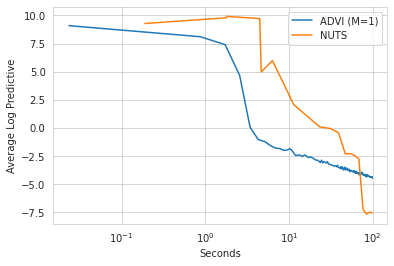

In [65]:
# Generate plot (Figure 4 in original paper)

output = output_advi.append(output_mcmc, ignore_index=True)
output = output.loc[output['t'] < 100]
output['test_accuracy'] = output['test_accuracy'].astype('float')

sns.set_style("whitegrid")
results = sns.lineplot(data = output, x = 't', y = 'test_accuracy', hue = 'model')
results.set(xscale='log', 
            xlim = (0.015, 150), 
            xlabel = 'Seconds',
            ylabel = 'Average Log Predictive')
plt.legend(labels=["ADVI (M=1)","NUTS"])